## Data Collection

Main data collection is processed by running ['update.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/update.py) on a Flask ['server.py'](https://github.com/cjunwon/Youtube-Data-Analysis/blob/main/server.py) scheduled through ngrok and Invictify.

This collection pipeline automatically updates the AWS MySQL RDS database with up-to-date channel statistics depending on the configured Invictify schedule.

In [2]:
from MySQL_DB_connect_functions import *
from MySQL_DB_update_functions import *
from youtube_api_functions import *

In [3]:
channel_id_list = ['UCIRYBXDze5krPDzAEOxFGVA'] #TheGuardian,NYTimes(UCqnbDFdCpuN8CMEg0VuEBqA)

In [4]:
# using youtube_api_functions.py:
youtube_obj = build_yt_API_object() # builds Youtube API object

In [5]:
video_df = create_video_df(youtube_obj, channel_id_list) # store API data into pandas df
processed_video_df = clean_video_df(video_df) # run df through cleaning function

In [6]:
processed_video_df.head()

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,favoriteCount,commentCount,caption,publishDayName,durationSecs,tagCount
0,_ovc5K41F2g,Guardian News,Canada police: we may never know what motivate...,The suspect sought by Canadian police over Sun...,2022-09-08,2440,30,0,16,0,Thursday,92.0,23
1,xas6x3xfGdo,Guardian News,Pakistan: hospitals struggle with influx of pa...,Hundreds of patients overwhelmed a hospital in...,2022-09-07,2747,51,0,15,0,Wednesday,136.0,38
2,6-kll84mjm8,Guardian News,Bridge collapses during ribbon-cutting ceremon...,Video verified by Reuters shows a bridge colla...,2022-09-07,60495,329,0,195,0,Wednesday,42.0,24
3,QmCeSZgRnck,Guardian News,Liz Truss and Keir Starmer face off for first ...,Prime minister Liz Truss went head-to-head wit...,2022-09-07,151310,1207,0,547,0,Wednesday,285.0,29
4,ZUdFzjIE8f0,Guardian News,Typhoon Hinnamnor: two rescued from undergroun...,Two people in South Korea were rescued in a dr...,2022-09-07,7311,91,0,8,0,Wednesday,86.0,34


In [7]:
video_ids = list(processed_video_df['video_id'])

In [8]:
all_comments_df = pd.DataFrame()
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    all_comments_df = all_comments_df.append(comment_data, ignore_index=True)

In [9]:
all_comments_df

,video_id,comment_id,comment,date
0,_ovc5K41F2g,UgwrkWG3qrLzq7GI1Zh4AaABAg,Could of took a cynaide pill..,2022-09-08T07:58:46Z
1,_ovc5K41F2g,UgzO7EHrKbIh8dpL9it4AaABAg,Rehabilitative justice led to this debacle...,2022-09-08T07:35:27Z
2,_ovc5K41F2g,UgzhP8e_15_YsWQrHe94AaABAg,How long till the comments get turned off I wo...,2022-09-08T07:13:18Z
3,_ovc5K41F2g,UgyR5a2JdhEslKwGo9R4AaABAg,He went into medical emergency after his arres...,2022-09-08T06:42:22Z
4,_ovc5K41F2g,UgwsM0uaXxpnpP1491h4AaABAg,If we’re looking for signs and symbology and d...,2022-09-08T06:32:21Z
...,...,...,...,...
3545,5tjtbvOxdxA,UgxBl5UOHoD6Wz0efoF4AaABAg,Nice footage.,2022-09-01T18:31:09Z
3546,5tjtbvOxdxA,UgwFZOG8oxIDqBW4AON4AaABAg,Ya ya ya ya yay 🤣🤣🤣,2022-09-01T18:19:43Z
3547,5tjtbvOxdxA,UgzrMpnoou-kdrhymER4AaABAg,Ukraine needs negotiations ASP.\nLift energy s...,2022-09-01T18:13:47Z
3548,5tjtbvOxdxA,Ugx_p6bbDlC2VD1GzSt4AaABAg,М777 ?,2022-09-01T18:13:12Z


In [10]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [11]:
all_comments_df['vader_sentiment'] = all_comments_df.comment.apply(lambda x: sia.polarity_scores(x))
all_comments_df['vader_comp_sentiment'] = all_comments_df.vader_sentiment.apply(lambda x: x['compound'])

In [12]:
all_comments_df['vader_comp_sentiment'].mean()

0.002725323943661922

In [20]:
video_comp_sentiments = pd.DataFrame(columns=['video_id', 'vid_title', 'avg_comp_sentiment', 'vid_viewcount'])
for video in video_ids:
    comment_data = get_video_comments(youtube_obj, video)
    comment_data['vader_sentiment'] = comment_data.comment.apply(lambda x: sia.polarity_scores(x))
    comment_data['vader_comp_sentiment'] = comment_data.vader_sentiment.apply(lambda x: x['compound'])
    comp_mean = comment_data['vader_comp_sentiment'].mean()

    vid_title = processed_video_df.loc[processed_video_df['video_id'] == video, 'title'].item()
    vid_viewcount = processed_video_df.loc[processed_video_df['video_id'] == video, 'viewCount'].item()

    dict = {'video_id': video,
            'vid_title': vid_title,
            'avg_comp_sentiment': comp_mean,
            'vid_viewcount': vid_viewcount
            }

    video_comp_sentiments = video_comp_sentiments.append(dict, ignore_index=True)
    

In [21]:
video_comp_sentiments

,video_id,vid_title,avg_comp_sentiment,vid_viewcount
0,_ovc5K41F2g,Canada police: we may never know what motivate...,0.051300,2440
1,xas6x3xfGdo,Pakistan: hospitals struggle with influx of pa...,0.145512,2747
2,6-kll84mjm8,Bridge collapses during ribbon-cutting ceremon...,0.020621,60495
3,QmCeSZgRnck,Liz Truss and Keir Starmer face off for first ...,-0.003203,151310
4,ZUdFzjIE8f0,Typhoon Hinnamnor: two rescued from undergroun...,-0.116643,7311
5,1ZCTQwljRqs,Liz Truss faces her first prime minister's que...,-0.017439,114866
6,rJngREUNLR8,Putin threatens to ‘freeze’ west by cutting ga...,-0.040704,53610
7,fkj2ZNJxN_8,Putin says election of Truss as UK leader ‘far...,-0.010683,32117
8,DMaVscjesfE,Thérèse Coffey's alarm goes off during LBC int...,0.069910,19323
9,zoBGZnueeBo,Ukraine: United Nations 'gravely concerned' ab...,-0.155679,6492


In [22]:
import seaborn as sns

<AxesSubplot:xlabel='avg_comp_sentiment', ylabel='vid_viewcount'>

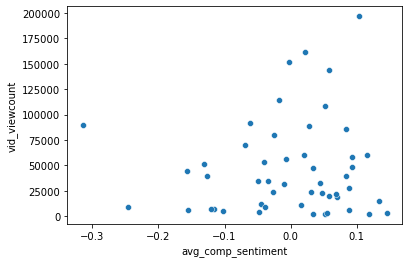

In [23]:
sns.scatterplot(data=video_comp_sentiments, x='avg_comp_sentiment', y='vid_viewcount')